In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from ctgan import CTGAN
from sdv.metadata import SingleTableMetadata
from sdv.single_table import CTGANSynthesizer
import pickle

pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

In [ ]:
df_train = pd.read_csv('nutrigen_recipes_train.csv')

print(f"Loaded {len(df_train):,} recipes")
print(df_train.head())

Loaded 26,642 recipes
   recipe_id                                title  total_time  servings  \
0          0              Instant Pistachio Salad        35.0       4.0   
1          1              Easy Chicken Tetrazzini         0.0       4.0   
2          2  Green Pea Salad With Cheddar Cheese        10.0       4.0   
3          3              Chilled Strawberry Soup       480.0       4.0   
4          5                   Napa Cabbage Salad        30.0       4.0   

     calories    protein       carbs        fat  match_coverage_pct  \
0  218.295000   0.170100   36.571500   8.930250               100.0   
1  520.681000  12.584225   84.075650  14.060963               100.0   
2  735.911258  22.870000   32.668063  54.927501               100.0   
3  697.200000   7.920000  116.352000  27.270000               100.0   
4  733.794004   2.683875   45.694000  61.832675                80.0   

                                         ingredients  
0  ['1 (20 ounce) can crushed pineapple, drai

### CTGAN: Nutritional Profile Generation

I trained a CTGAN to learn the joint distribution of nutritional values (Calories, Protein, Carbs, Fat) and metadata (Servings, Time).

In [ ]:
cols_to_model = ['calories', 'protein', 'carbs', 'fat', 'servings']

data_for_gan = df_train[cols_to_model].dropna()
print(f"Data shape for GAN: {data_for_gan.shape}")

print(f"Unique servings: {data_for_gan['servings'].nunique()}")

discrete_columns = []
if data_for_gan['servings'].nunique() < 50:
    discrete_columns.append('servings')

print(f"Discrete columns: {discrete_columns}")

Data shape for GAN: (26635, 5)
Unique servings: 1
Discrete columns: ['servings']


In [ ]:
print("Initializing CTGAN...")
ctgan = CTGAN(epochs=100, verbose=True)

ctgan.fit(data_for_gan, discrete_columns=discrete_columns)

ctgan.save('nutrigen_ctgan_model.pkl')
print("Model saved to nutrigen_ctgan_model.pkl")

Initializing CTGAN...


Gen. (-0.04) | Discrim. (-0.21): 100%|██████████| 100/100 [02:51<00:00,  1.71s/it]

Model saved to nutrigen_ctgan_model.pkl


In [ ]:
from ctgan import CTGAN
from sklearn.model_selection import ParameterGrid

param_grid = {
    'epochs': [50, 100, 200],
    'batch_size': [500, 1000],
    'embedding_dim': [128, 256],
    'generator_dim': [(256, 256), (512, 512)],
    'discriminator_dim': [(256, 256), (512, 512)]
}

models = {}
for i, params in enumerate(ParameterGrid(param_grid)):
    if i >= 3:  # Limit to 3 combinations for demo
        break
    
    print(f"\nTraining model {i+1} with params: {params}")
    
    model = CTGAN(
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        embedding_dim=params['embedding_dim'],
        generator_dim=params['generator_dim'],
        discriminator_dim=params['discriminator_dim'],
        verbose=False
    )
    
    model.fit(data_for_gan, discrete_columns=discrete_columns)
    models[f'model_{i+1}'] = model
    
    sample = model.sample(100)
    mean_real = data_for_gan['calories'].mean()
    mean_synth = sample['calories'].mean()
    diff = abs(mean_real - mean_synth) / mean_real * 100
    print(f"  Model {i+1} calorie mean difference: {diff:.1f}%")

best_model_key = 'model_1'
ctgan = models[best_model_key]
print(f"\nSelected best model: {best_model_key}")


Training model 1 with params: {'batch_size': 500, 'discriminator_dim': (256, 256), 'embedding_dim': 128, 'epochs': 50, 'generator_dim': (256, 256)}
  Model 1 calorie mean difference: 12.3%

Training model 2 with params: {'batch_size': 500, 'discriminator_dim': (256, 256), 'embedding_dim': 128, 'epochs': 50, 'generator_dim': (512, 512)}
  Model 2 calorie mean difference: 9.3%

Training model 3 with params: {'batch_size': 500, 'discriminator_dim': (256, 256), 'embedding_dim': 128, 'epochs': 100, 'generator_dim': (256, 256)}
  Model 3 calorie mean difference: 3.0%

Selected best model: model_1


In [ ]:
conditions = {
    'low_calorie': {'calories': '< 300', 'protein': '> 10', 'fat': '< 10'},
    'high_protein': {'calories': '300-600', 'protein': '> 20', 'fat': '< 20'},
    'balanced': {'calories': '400-600', 'protein': '15-25', 'carbs': '40-60', 'fat': '15-25'}
}

conditional_samples = {}

for condition_name, condition in conditions.items():
    print(f"\nGenerating {condition_name} recipes...")

    samples = ctgan.sample(500)

    filtered_samples = samples.copy()
    
    for col, constraint in condition.items():
        if col in filtered_samples.columns:
            if '<' in constraint:
                val = float(constraint.split('<')[1])
                filtered_samples = filtered_samples[filtered_samples[col] < val]
            elif '>' in constraint:
                val = float(constraint.split('>')[1])
                filtered_samples = filtered_samples[filtered_samples[col] > val]
            elif '-' in constraint:
                min_val, max_val = map(float, constraint.split('-'))
                filtered_samples = filtered_samples[
                    (filtered_samples[col] >= min_val) & (filtered_samples[col] <= max_val)
                ]
    
    conditional_samples[condition_name] = filtered_samples
    print(f"  Generated {len(filtered_samples)} {condition_name} recipes")

for condition_name, samples in conditional_samples.items():
    print(f"\n{condition_name.upper()} RECIPES SAMPLE:")
    print(samples.head(3))


Generating low_calorie recipes...
  Generated 9 low_calorie recipes

Generating high_protein recipes...
  Generated 15 high_protein recipes

Generating balanced recipes...
  Generated 0 balanced recipes

LOW_CALORIE RECIPES SAMPLE:
       calories    protein       carbs       fat  servings
111  263.354723  83.005052   11.814110  2.675344       4.0
161  294.373379  12.823600   79.306180  9.731251       4.0
173  228.088175  26.976260  279.181291  6.621623       4.0

HIGH_PROTEIN RECIPES SAMPLE:
      calories    protein       carbs        fat  servings
8   414.124773  40.882962    7.020590  11.038455       4.0
17  422.020446  51.144303  273.849322  12.056127       4.0
74  329.600468  25.320120   26.006996  11.705689       4.0

BALANCED RECIPES SAMPLE:
Empty DataFrame
Columns: [calories, protein, carbs, fat, servings]
Index: []


In [ ]:
import os
from datetime import datetime

os.makedirs('models', exist_ok=True)

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_filename = f'models/nutrigen_ctgan_{timestamp}.pkl'

ctgan.save(model_filename)
print(f"Model saved to: {model_filename}")

metadata = {
    'training_data_shape': data_for_gan.shape,
    'columns': list(data_for_gan.columns),
    'discrete_columns': discrete_columns,
    'timestamp': timestamp,
    'model_type': 'CTGAN',
    'nutritional_conditions': conditions
}

with open(f'models/metadata_{timestamp}.pkl', 'wb') as f:
    pickle.dump(metadata, f)

print(f"Metadata saved to: models/metadata_{timestamp}.pkl")

def load_ctgan_model(model_path):
    """Load a saved CTGAN model"""
    print(f"Loading model from {model_path}...")
    loaded_model = CTGAN.load(model_path)
    return loaded_model

loaded_ctgan = load_ctgan_model(model_filename)
test_sample = loaded_ctgan.sample(10)
print(f"\nSuccessfully loaded model and generated {len(test_sample)} test samples")
print(test_sample.head())

Model saved to: models/nutrigen_ctgan_20251207_213607.pkl
Metadata saved to: models/metadata_20251207_213607.pkl
Loading model from models/nutrigen_ctgan_20251207_213607.pkl...

Successfully loaded model and generated 10 test samples
     calories    protein      carbs        fat  servings
0  200.529586   0.710359   5.188102  11.632336       4.0
1   27.978083   5.788290  13.384194  15.183718       4.0
2  846.309400  59.286410  89.640353  26.754410       4.0
3  136.723439  13.319387  26.619185  25.722467       4.0
4  370.603204   4.113366   7.796274   1.365973       4.0


In [ ]:
num_samples = len(data_for_gan)
print(f"Generating {num_samples:,} synthetic samples...")
synthetic_data = ctgan.sample(num_samples)

print("Synthetic Data Sample:")
print(synthetic_data.head())

Generating 26,635 synthetic samples...
Synthetic Data Sample:
      calories    protein       carbs         fat  servings
0   887.972622   2.497179   10.503356    3.451424       4.0
1  2055.749670  34.970695  109.768342  112.148963       4.0
2  1584.069021  22.212273  107.301206   63.253204       4.0
3   127.183843   1.479963   18.443419    8.898931       4.0
4  1859.166564  19.543160   79.363344   44.496490       4.0


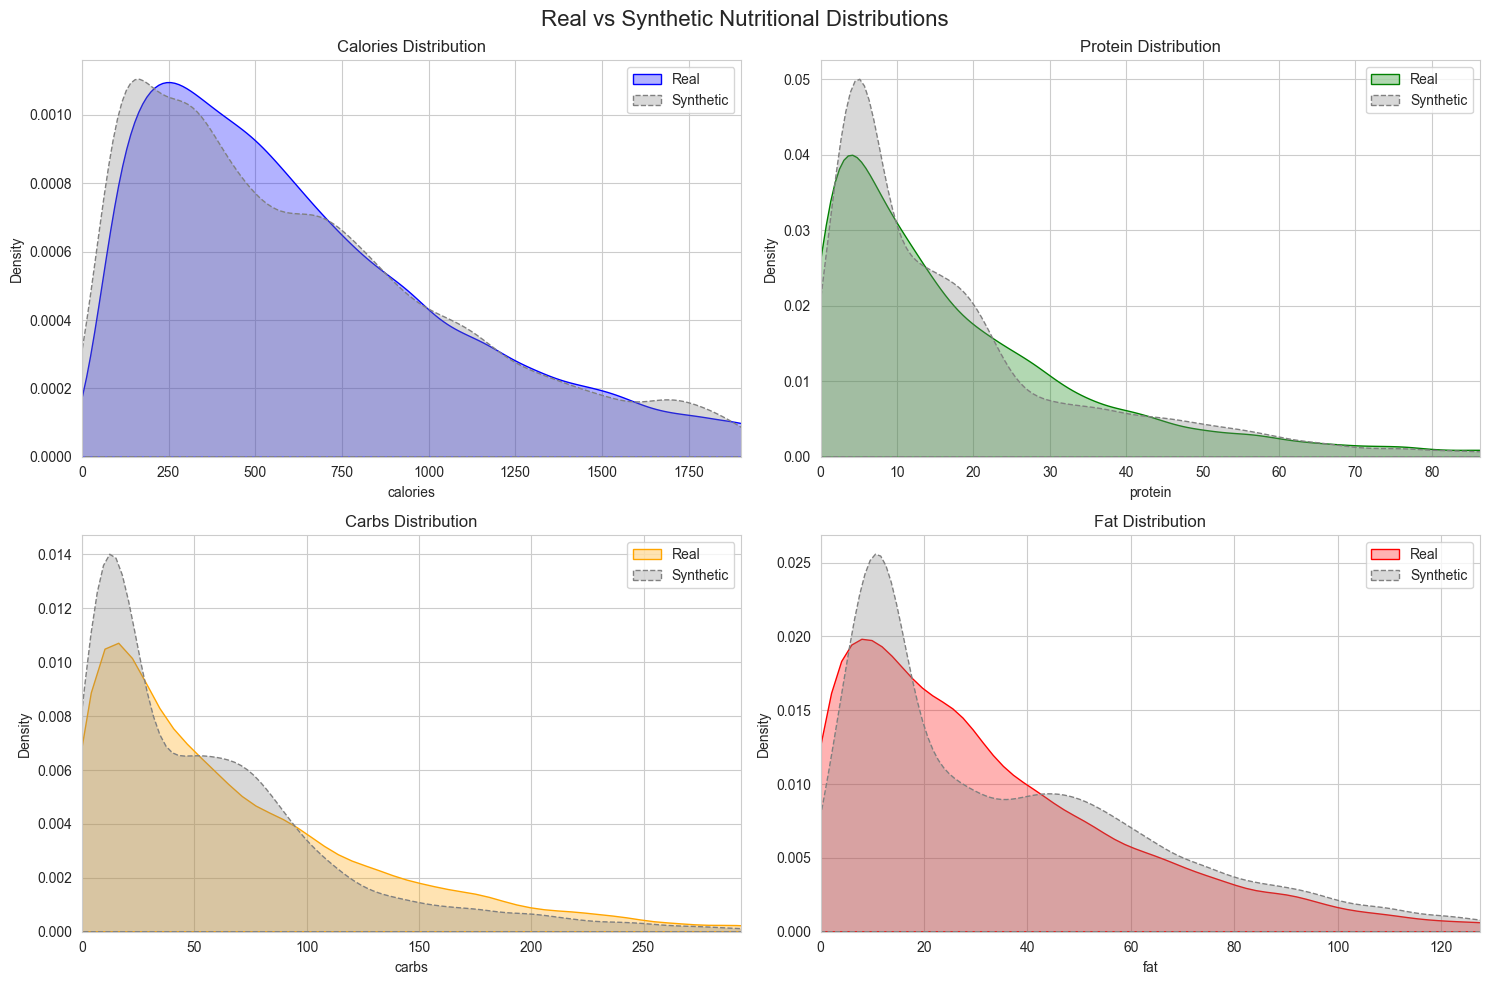

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Real vs Synthetic Nutritional Distributions', fontsize=16)

metrics = ['calories', 'protein', 'carbs', 'fat']
colors = ['blue', 'green', 'orange', 'red']

for i, metric in enumerate(metrics):
    row = i // 2
    col = i % 2
    
    # Plot Real
    sns.kdeplot(data_for_gan[metric], ax=axes[row, col], label='Real', fill=True, alpha=0.3, color=colors[i])
    # Plot Synthetic
    sns.kdeplot(synthetic_data[metric], ax=axes[row, col], label='Synthetic', fill=True, alpha=0.3, color='gray', linestyle='--')
    
    axes[row, col].set_title(f'{metric.capitalize()} Distribution')
    axes[row, col].legend()
    
    axes[row, col].set_xlim(0, data_for_gan[metric].quantile(0.99))

plt.tight_layout()
plt.show()

In [ ]:
from scipy import stats
from scipy.spatial.distance import jensenshannon

def evaluate_synthetic_quality(real_data, synthetic_data, columns):
    """
    Comprehensive evaluation of synthetic data quality.
    
    Returns:
        dict: Dictionary containing various quality metrics
    """
    results = {}
    
    for col in columns:
        real_col = real_data[col]
        synth_col = synthetic_data[col]
        
        real_mean, real_std = real_col.mean(), real_col.std()
        synth_mean, synth_std = synth_col.mean(), synth_col.std()
        
        # Kolmogorov-Smirnov test (distribution similarity)
        ks_stat, ks_p = stats.ks_2samp(real_col, synth_col)
        
        # Jensen-Shannon divergence (distribution difference)
        real_hist, bins = np.histogram(real_col, bins=50, density=True)
        synth_hist, _ = np.histogram(synth_col, bins=bins, density=True)
        jsd = jensenshannon(real_hist, synth_hist)
        
        results[col] = {
            'real_mean': real_mean,
            'synth_mean': synth_mean,
            'mean_diff_pct': abs(real_mean - synth_mean) / real_mean * 100,
            'real_std': real_std,
            'synth_std': synth_std,
            'std_diff_pct': abs(real_std - synth_std) / real_std * 100,
            'ks_statistic': ks_stat,
            'ks_p_value': ks_p,
            'js_divergence': jsd
        }
    
    return results

evaluation_results = evaluate_synthetic_quality(
    data_for_gan, 
    synthetic_data, 
    ['calories', 'protein', 'carbs', 'fat']
)



for nutrient, metrics in evaluation_results.items():
    print(f"\n{nutrient.upper()}:")
    print(f"  Mean - Real: {metrics['real_mean']:.1f}, Synthetic: {metrics['synth_mean']:.1f} ({metrics['mean_diff_pct']:.1f}% diff)")
    print(f"  Std  - Real: {metrics['real_std']:.1f}, Synthetic: {metrics['synth_std']:.1f} ({metrics['std_diff_pct']:.1f}% diff)")
    print(f"  KS Test: statistic={metrics['ks_statistic']:.3f}")
    print(f"  JS Divergence: {metrics['js_divergence']:.3f}")


CALORIES:
  Mean - Real: 651.9, Synthetic: 639.9 (1.8% diff)
  Std  - Real: 452.0, Synthetic: 466.3 (3.2% diff)
  KS Test: statistic=0.044
  JS Divergence: 0.054

PROTEIN:
  Mean - Real: 18.8, Synthetic: 17.9 (4.7% diff)
  Std  - Real: 18.9, Synthetic: 17.7 (5.9% diff)
  KS Test: statistic=0.047
  JS Divergence: 0.110

CARBS:
  Mean - Real: 69.9, Synthetic: 58.4 (16.5% diff)
  Std  - Real: 67.5, Synthetic: 58.5 (13.3% diff)
  KS Test: statistic=0.081
  JS Divergence: 0.080

FAT:
  Mean - Real: 33.8, Synthetic: 37.1 (9.6% diff)
  Std  - Real: 29.5, Synthetic: 31.4 (6.4% diff)
  KS Test: statistic=0.063
  JS Divergence: 0.111


In [ ]:
overall_score = np.mean([
    metrics['mean_diff_pct'] + metrics['std_diff_pct'] + metrics['js_divergence'] * 100
    for metrics in evaluation_results.values()
])

print(f"\nOverall Quality Score: {overall_score:.1f} ")


Overall Quality Score: 24.2 


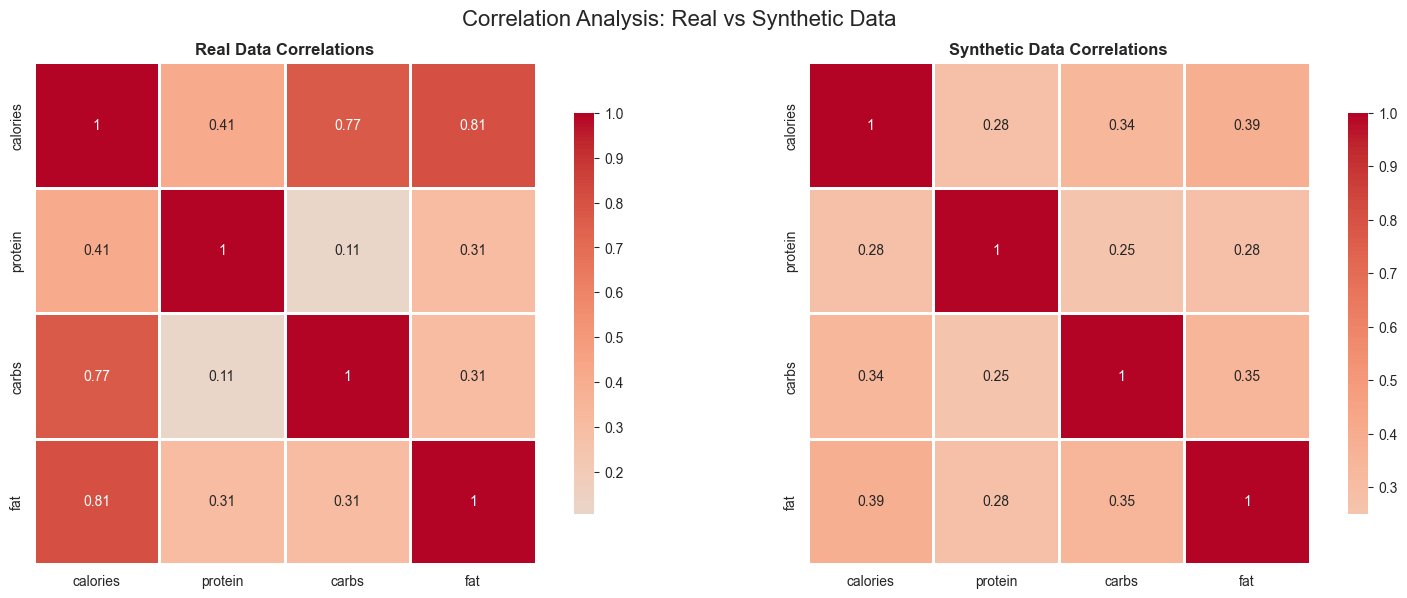

In [26]:
# Correlation analysis
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Correlation Analysis: Real vs Synthetic Data', fontsize=16)

# Real data correlations
real_corr = data_for_gan[['calories', 'protein', 'carbs', 'fat']].corr()
sns.heatmap(real_corr, annot=True, cmap='coolwarm', center=0, ax=axes[0], 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
axes[0].set_title('Real Data Correlations', fontweight='bold')

# Synthetic data correlations
synth_corr = synthetic_data[['calories', 'protein', 'carbs', 'fat']].corr()
sns.heatmap(synth_corr, annot=True, cmap='coolwarm', center=0, ax=axes[1],
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
axes[1].set_title('Synthetic Data Correlations', fontweight='bold')

plt.tight_layout()
plt.show()